In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import rasterio as rio

from sklearn.svm import OneClassSVM
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.mixture import GaussianMixture

#roywright
from baggingPU import BaggingClassifierPU

### Rendering TIFs and Data Preprocessing

In [3]:
tifFolder = 'newTIFs/'

# read in all tifs
obs10mArray = plt.imread(tifFolder + 'buffer311_10m.tif')
TWIarray = plt.imread(tifFolder + 'Topographic_Wetness_Index.tif')
HWBarray = plt.imread(tifFolder + 'Historical_Water_Bodies.tif')
IMParray = plt.imread(tifFolder + 'Impervious_Cover.tif')
CSarray = plt.imread(tifFolder + 'Combined_Sewer.tif')
SSarray = plt.imread(tifFolder + 'Separate_Sewer.tif')
DSarray = plt.imread(tifFolder + 'Direct_Sewer.tif')
OSarray = plt.imread(tifFolder + 'Other_Sewer.tif')
BMarray = plt.imread(tifFolder + 'Building_mask.tif')

In [4]:
# check dimensions - they must be the same
imageArrays = obs10mArray, TWIarray, HWBarray, IMParray, CSarray, SSarray, DSarray, OSarray, BMarray
for array in imageArrays:
    print(array.shape)

(6282, 6331)
(6282, 6331, 4)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)


TWIarray has three dimensions. The first three layers of the third axis are identical so we take the second stack of 6282 by 6331.

In [5]:
TWIarray_new = np.delete(TWIarray, [0, 2, 3], axis=2).reshape(6282, 6331)

In [6]:
# check dimensions again
imageArrays = obs10mArray, TWIarray_new, HWBarray, IMParray, CSarray, SSarray, DSarray, OSarray, BMarray
for array in imageArrays:
    print(array.shape)

(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)
(6282, 6331)


### Check values of arrays
- observations, sewers, historical water bodies, and building mask should have values of 0, 1, or 255
- TWI and Imperviousness should have values of 0 to 100 and 255
- 255 is disregarded

In [7]:
for array in imageArrays:
    print(np.unique(array))
    print('')

[  0   1 255]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 255]

[  0   1 255]

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 255]

[  0   1 255]

[  0   1 255]

[  0   1 255]

[  0   1 255]

[  0   1 255]



Text(0.5,1,'Others')

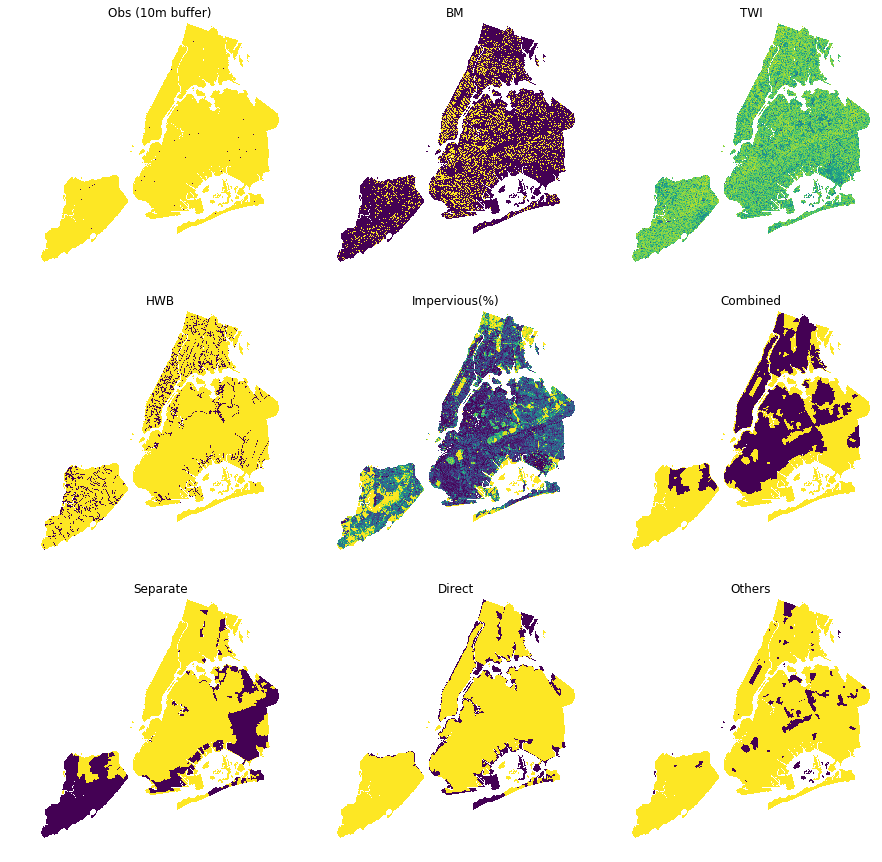

In [8]:
# visualize arrays

plt.figure(figsize=(15,15))
cmap = plt.cm.viridis_r
cmap.set_over('white')

ax1 = plt.subplot(3,3,1)
ax1.imshow(obs10mArray, vmin=0, vmax=1, cmap=cmap)
ax1.set_axis_off()
ax1.set_title('Obs (10m buffer)')

ax2 = plt.subplot(3,3,2)
ax2.imshow(BMarray, vmin=0, vmax=1, cmap=cmap)
ax2.set_axis_off()
ax2.set_title('BM')

ax3 = plt.subplot(3,3,3)
ax3.imshow(TWIarray_new, vmin=0, vmax=100, cmap=cmap)
ax3.set_axis_off()
ax3.set_title('TWI')

ax4 = plt.subplot(3,3,4)
ax4.imshow(HWBarray, vmin=0, vmax=1, cmap=cmap)
ax4.set_axis_off()
ax4.set_title('HWB')

ax5 = plt.subplot(3,3,5)
ax5.imshow(IMParray, vmin=0, vmax=100, cmap=cmap)
ax5.set_axis_off()
ax5.set_title('Impervious(%)')

ax6 = plt.subplot(3,3,6)
ax6.imshow(CSarray, vmin=0, vmax=1, cmap=cmap)
ax6.set_axis_off()
ax6.set_title('Combined')

ax7 = plt.subplot(3,3,7)
ax7.imshow(SSarray, vmin=0, vmax=1, cmap=cmap)
ax7.set_axis_off()
ax7.set_title('Separate')

ax8 = plt.subplot(3,3,8)
ax8.imshow(DSarray, vmin=0, vmax=1, cmap=cmap)
ax8.set_axis_off()
ax8.set_title('Direct')

ax9 = plt.subplot(3,3,9)
ax9.imshow(OSarray, vmin=0, vmax=1, cmap=cmap)
ax9.set_axis_off()
ax9.set_title('Others')

### Stacking rasters

In [9]:
arrays10m = TWIarray_new, HWBarray, IMParray, CSarray, SSarray, DSarray, OSarray, BMarray, obs10mArray
stacked10m = np.dstack(arrays10m)
print(stacked10m.shape)

(6282, 6331, 9)


In [10]:
final10m = stacked10m.reshape((39771342, 9))
print(final10m.shape)

(39771342, 9)


In [11]:
# checking
print(final10m[23000000])

[21  0 68  0  1  0  0  1  0]


### Convert to pandas dataframes and save as csv (back up)
- uncomment to save as csv

In [12]:
columnNames = ['twi', 'hwb', 'imp', 'cs', 'ss', 'ds', 'os', 'bm', 'observed']

In [13]:
df10m = pd.DataFrame(final10m, columns=columnNames)
#df10m.to_csv('df10m.csv', index=False)

In [14]:
df10m.head()

,twi,hwb,imp,cs,ss,ds,os,bm,observed
0,255,255,255,255,255,255,255,255,255
1,255,255,255,255,255,255,255,255,255
2,255,255,255,255,255,255,255,255,255
3,255,255,255,255,255,255,255,255,255
4,255,255,255,255,255,255,255,255,255


### Remove rows containing 255 and save as csv with index (back up)
- uncomment to save as csv

In [15]:
# get indices of rows containing 255
nanindex_10m = np.unique(np.where(final10m == 255)[0])

# drop rows from df
df10m_nonan = df10m.drop(index=nanindex_10m)

print('Number of Rows Before: '+str(len(df10m)))
print('Number of Rows After: '+str(len(df10m_nonan)))

#save as csv with index
#df10m_nonan.to_csv('df10m_noNaN.csv', index=True, index_label='Index')

Number of Rows Before: 39771342
Number of Rows After: 13746346


In [16]:
df10m_nonan.head()

,twi,hwb,imp,cs,ss,ds,os,bm,observed
225463,12,0,0,0,0,1,0,1,0
231793,16,0,0,0,0,1,0,1,0
231794,32,0,0,0,0,1,0,1,0
231795,39,0,0,0,0,1,0,1,0
231796,21,0,0,0,0,1,0,1,0


In [17]:
# check number of positive pixels
print('10m buffer:')
print(df10m_nonan['observed'].value_counts())

10m buffer:
0    13724427
1       21919
Name: observed, dtype: int64


### Positive-Unlabeled (PU) Learning:
- Roy Wright Example Run-Through [[1]](!https://roywright.me/2017/11/16/positive-unlabeled-learning)
- Building Text Classifiers Using Positive and Unlabeled Examples Paper [[2]](!http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.9.5405&rep=rep1&type=pdf)
    - Assuming out of 10 floods, only 1 person calls (90% of positives unlabeled), use PU Bagging Method
    - Assuming out of 10 floods, 7 people call (30% of positives unlabeled), use Standard Classifier Method [[3]](!http://cseweb.ucsd.edu/~elkan/posonly.pdf)

In [18]:
# create copy for unlabeling
unlabel = df10m_nonan['observed'].copy()

# unlabel ~30% of positive data points, i.e. 6500 points
hidden_size = 6500
np.random.seed(seed=13)
unlabel.loc[np.random.choice(unlabel[unlabel == 1].index, replace=False, size=hidden_size)] = 0

# add unlabeled y column to df
df10m_nonan['y_un_30pct'] = unlabel
df10m_nonan.head()

print('Original: ')
print(df10m_nonan['observed'].value_counts())
print('')
print('After unlabeling: ')
print(df10m_nonan['y_un_30pct'].value_counts())

Original: 
0    13724427
1       21919
Name: observed, dtype: int64

After unlabeling: 
0    13730927
1       15419
Name: y_un_30pct, dtype: int64


In [19]:
X = df10m_nonan.iloc[:,:8]
y = df10m_nonan['y_un_30pct']

### Checking distirbution of positives after unlabeling

In [20]:
dist = pd.merge(df10m, df10m_nonan['y_un_30pct'], how='outer', left_index=True, right_index=True)
dist.fillna(255, inplace=True)
distArray = np.reshape(np.array(dist['y_un_30pct']), (6282, 6331))

Text(0.5,1,'After Unlabeling (10m buffer)')

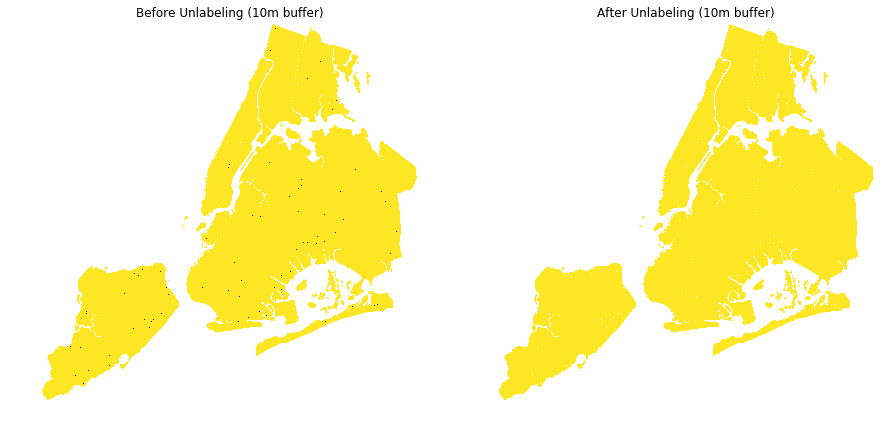

In [21]:
plt.figure(figsize=(15,8))
cmap = plt.cm.viridis_r
cmap.set_over('white')

ax1 = plt.subplot(1,2,1)
ax1.imshow(obs10mArray, vmin=0, vmax=1, cmap=cmap)
ax1.set_axis_off()
ax1.set_title('Before Unlabeling (10m buffer)')

ax2 = plt.subplot(1,2,2)
ax2.imshow(distArray, vmin=0, vmax=1, cmap=cmap)
ax2.set_axis_off()
ax2.set_title('After Unlabeling (10m buffer)')

Seems to be sampled evenly, no one spot shows up.

### Gaussian Mixture Model using all features

In [23]:
gmmX = df10m_nonan[df10m_nonan['y_un_30pct']==1].iloc[:,:8]
gmmX.head()

,twi,hwb,imp,cs,ss,ds,os,bm
681346,28,0,10,1,0,0,0,1
681347,31,0,7,1,0,0,0,1
687677,18,0,10,1,0,0,0,1
713051,19,0,69,1,0,0,0,1
713052,51,0,68,1,0,0,0,1


In [24]:
GMM = GaussianMixture(n_components=1, random_state=13)
GMM.fit(gmmX)

GaussianMixture(covariance_type='full', init_params='kmeans', max_iter=100,
        means_init=None, n_components=1, n_init=1, precisions_init=None,
        random_state=13, reg_covar=1e-06, tol=0.001, verbose=0,
        verbose_interval=10, warm_start=False, weights_init=None)

In [29]:
df10m_nonan['gmmscore'] = GMM.score_samples(df10m_nonan.iloc[:,:8])
df10m_nonan['gmmscore_exp'] = np.exp(df10m_nonan['gmmscore'])

Check number of hidden positives in top 10%, 15%, and 20% of data.

In [106]:
gmmSorted = df10m_nonan.sort_values('gmmscore', ascending=False)

gmm10 = gmmSorted[:1374634]
unCounts_gmm = len(gmm10[(gmm10['observed']==1)&(gmm10['y_un_30pct']==0)])
pctPos_gmm = unCounts_gmm*100.0/6500
print('Percentage of hidden positives in top 10 percent uncovered: %.2f percent' %pctPos_gmm)

gmm15 = gmmSorted[:2061952]
unCounts_gmm = len(gmm15[(gmm15['observed']==1)&(gmm15['y_un_30pct']==0)])
pctPos_gmm = unCounts_gmm*100.0/6500
print('Percentage of hidden positives in top 15 percent uncovered: %.2f percent' %pctPos_gmm)

gmm20 = gmmSorted[:2749268]
unCounts_gmm = len(gmm20[(gmm20['observed']==1)&(gmm20['y_un_30pct']==0)])
pctPos_gmm = unCounts_gmm*100.0/6500
print('Percentage of hidden positives in top 20 percent uncovered: %.2f percent' %pctPos_gmm)

Percentage of hidden positives in top 10 percent uncovered: 22.72 percent
Percentage of hidden positives in top 15 percent uncovered: 33.15 percent
Percentage of hidden positives in top 20 percent uncovered: 42.78 percent


In [34]:
gmmdf = df10m.merge(df10m_nonan['gmmscore_exp'], how='outer', left_index=True, right_index=True)
gmmdf['gmmscore_exp'].fillna(255, inplace=True)
gmmplot = np.reshape(np.array(gmmdf['gmmscore_exp']), (6282, 6331))

(-0.5, 6330.5, 6281.5, -0.5)

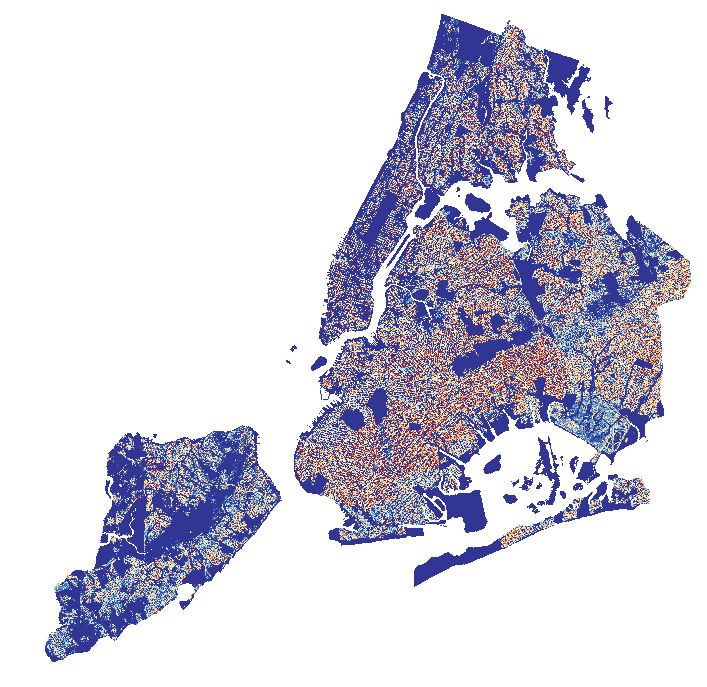

In [69]:
plt.figure(figsize=(12,12))
cmap=plt.cm.RdYlBu_r
cmap.set_over('white')
plt.imshow(gmmplot, vmin=0, vmax=1.4, cmap=cmap)
plt.axis('off')

### Saving as raster:

In [60]:
with rio.open(tifFolder + 'Historical_Water_Bodies.tif') as src:
    hwb_ras = src.read()
    hwb_meta = src.profile
    
print(hwb_meta)

{'count': 1, 'crs': CRS.from_epsg(32618), 'interleave': 'band', 'dtype': 'uint8', 'driver': u'GTiff', 'transform': Affine(7.500035678781709, 0.0, 562667.8236606269,
       0.0, -7.500035678781776, 4530170.840125717), 'height': 6282, 'width': 6331, 'blockxsize': 128, 'tiled': True, 'blockysize': 128, 'nodata': 255.0}


In [61]:
# change datatype to 'uint8'
gmmtif = gmmplot.astype('uint8')

#writing and saving as raster
with rio.open('gmm.tif', 'w', **hwb_meta) as dst:
    dst.write(gmmtif, 1)

### Random Forest Classification (n_estimators=50)

In [193]:
rf = RandomForestClassifier(n_estimators=50, n_jobs=-1, random_state=13)
rf.fit(X, y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,
            oob_score=False, random_state=13, verbose=0, warm_start=False)

In [194]:
df10m_nonan['rf_50'] = rf.predict_proba(X)[:,1]
df10m_nonan['rf_50'].describe()

count    1.374635e+07
mean     1.122799e-03
std      2.859672e-03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.596208e-03
max      6.600099e-01
Name: rf_50, dtype: float64

(-0.001, 0.005)

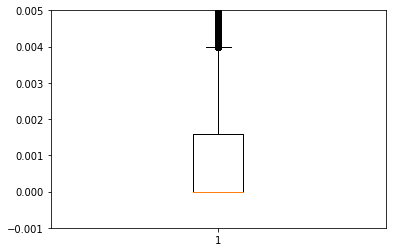

In [195]:
plt.boxplot(df10m_nonan['rf_50'])
plt.ylim(-0.001, 0.005)

Check number of hidden positives in top 10%, 15% and 20% of data.

In [107]:
rfSorted = df10m_nonan.sort_values('rf_50', ascending=False)

rf10 = rfSorted[:1374634]
unCounts_rf = len(rf10[(rf10['observed']==1)&(rf10['y_un_30pct']==0)])
pctPos_rf = unCounts_rf*100.0/6500
print('Percentage of hidden positives in top 10 percent uncovered: %.2f percent' %pctPos_rf)

rf15 = rfSorted[:2061952]
unCounts_rf = len(rf15[(rf15['observed']==1)&(rf15['y_un_30pct']==0)])
pctPos_rf = unCounts_rf*100.0/6500
print('Percentage of hidden positives in top 15 percent uncovered: %.2f percent' %pctPos_rf)

rf20 = rfSorted[:2749268]
unCounts_rf = len(rf20[(rf20['observed']==1)&(rf20['y_un_30pct']==0)])
pctPos_rf = unCounts_rf*100.0/6500
print('Percentage of hidden positives in top 20 percent uncovered: %.2f percent' %pctPos_rf)

Percentage of hidden positives in top 10 percent uncovered: 30.32 percent
Percentage of hidden positives in top 15 percent uncovered: 40.89 percent
Percentage of hidden positives in top 20 percent uncovered: 50.09 percent


Accuracy improved.

In [192]:
df10m_nonan.head()

,twi,hwb,imp,cs,ss,ds,os,bm,observed,y_un_30pct,gmmscore,gmmscore_exp,rf_30,bc_30,tsm
225463,12,0,0,0,0,1,0,1,0,0,-27.039072,1.807509e-12,0.0,0.0,0.0
231793,16,0,0,0,0,1,0,1,0,0,-26.546548,2.957881e-12,0.0,0.0,0.0
231794,32,0,0,0,0,1,0,1,0,0,-25.581105,7.767253e-12,0.0,0.0,0.0
231795,39,0,0,0,0,1,0,1,0,0,-25.664189,7.147999e-12,0.0,0.0,0.0
231796,21,0,0,0,0,1,0,1,0,0,-26.072172,4.753347e-12,0.0,0.0,0.0


In [196]:
rfdf = df10m.merge(df10m_nonan['rf_30'], how='outer', left_index=True, right_index=True)
#rfdf['rf_30'].fillna(255, inplace=True)
rfplot = np.reshape(np.array(rfdf['rf_30']), (6282, 6331))

(-0.5, 6330.5, 6281.5, -0.5)

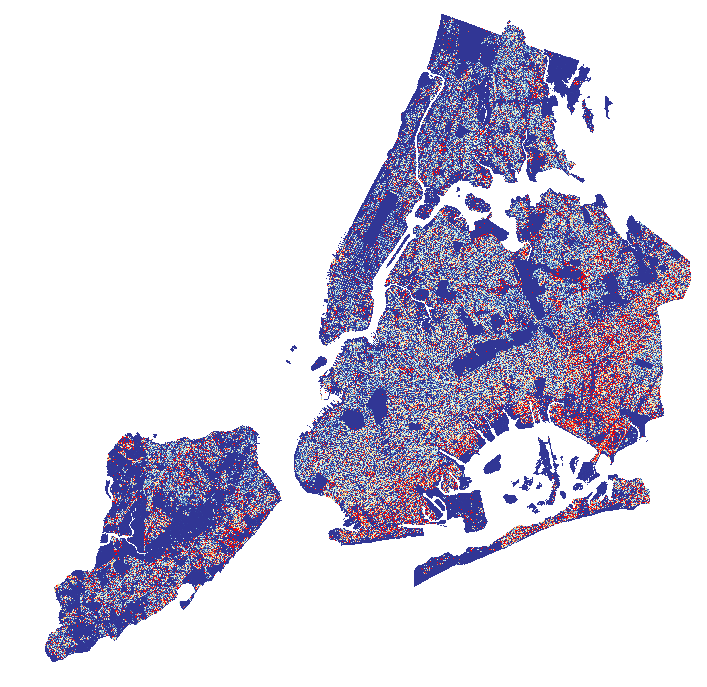

In [197]:
plt.figure(figsize=(12,12))
cmap=plt.cm.RdYlBu_r
cmap.set_over('red')
cmap.set_bad('white')
plt.imshow(rfplot, vmin=0, vmax=0.0045, cmap=cmap)
plt.axis('off')

In [202]:
# change nans to 255 for reading on arcGIS
rfdf['rf_30'].fillna(255, inplace=True)
rfplot = np.reshape(np.array(rfdf['rf_30']), (6282, 6331))

In [203]:
with rio.open(tifFolder + 'Historical_Water_Bodies.tif') as src:
    hwb_ras = src.read()
    hwb_meta = src.profile
    
print(hwb_meta)

{'count': 1, 'crs': CRS.from_epsg(32618), 'interleave': 'band', 'dtype': 'uint8', 'driver': u'GTiff', 'transform': Affine(7.500035678781709, 0.0, 562667.8236606269,
       0.0, -7.500035678781776, 4530170.840125717), 'height': 6282, 'width': 6331, 'blockxsize': 128, 'tiled': True, 'blockysize': 128, 'nodata': 255.0}


In [205]:
np.unique(rfplot)

array([0.00000000e+00, 1.18273211e-06, 6.74763833e-06, ...,
       6.60000000e-01, 6.60009926e-01, 2.55000000e+02])

In [206]:
# change datatype to 'uint8'
rftif = rfplot.astype('uint8')

#writing and saving as raster
with rio.open('rf.tif', 'w', **hwb_meta) as dst:
    dst.write(rftif, 1)

### PU Bagging Approach (n_estimators=30)

In [94]:
bc = BaggingClassifierPU(DecisionTreeClassifier(), 
                          n_estimators=30, n_jobs=-1, 
                          random_state=13, max_samples=sum(y))
bc.fit(X, y)

BaggingClassifierPU(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best'),
          bootstrap=True, bootstrap_features=False, max_features=1.0,
          max_samples=15419, n_estimators=30, n_jobs=-1, oob_score=True,
          random_state=13, verbose=0, warm_start=False)

In [95]:
df10m_nonan['bc_30'] = bc.oob_decision_function_[:,1]
df10m_nonan['bc_30'].describe()

count    1.373093e+07
mean     3.349545e-01
std      3.321906e-01
min      0.000000e+00
25%      0.000000e+00
50%      2.756746e-01
75%      6.535154e-01
max      1.000000e+00
Name: bc_30, dtype: float64

Check number of hidden positives in top 10% of data.

In [112]:
bcSorted = df10m_nonan.sort_values('bc_30', ascending=False)

bc10 = bcSorted[:1374634]
unCounts_bc = len(bc10[(bc10['observed']==1)&(bc10['y_un_30pct']==0)])
pctPos_bc = unCounts_bc*100.0/6500
print('Percentage of hidden positives in top 10 percent uncovered: %.2f percent' %pctPos_bc)

bc15 = bcSorted[:2061952]
unCounts_bc = len(bc15[(bc15['observed']==1)&(bc15['y_un_30pct']==0)])
pctPos_bc = unCounts_bc*100.0/6500
print('Percentage of hidden positives in top 15 percent uncovered: %.2f percent' %pctPos_bc)

bc20 = bcSorted[:2749268]
unCounts_bc = len(bc20[(bc20['observed']==1)&(bc20['y_un_30pct']==0)])
pctPos_bc = unCounts_bc*100.0/6500
print('Percentage of hidden positives in top 20 percent uncovered: %.2f percent' %pctPos_bc)

Percentage of hidden positives in top 10 percent uncovered: 30.92 percent
Percentage of hidden positives in top 15 percent uncovered: 42.86 percent
Percentage of hidden positives in top 20 percent uncovered: 52.42 percent


In [98]:
print('Number of NaNs (positives): ')
print(df10m_nonan['bc_30'].isna().sum())
print(' ')

# replace NaNs with 1 for plotting
df10m_nonan['bc_30'].fillna(1, inplace=True)

print('Number of NaNs: ')
print(df10m_nonan['bc_30'].isna().sum())

Number of NaNs (positives): 
15419
 
Number of NaNs: 
0


{'boxes': [<matplotlib.lines.Line2D at 0x7ff09b2bbd10>],
 'caps': [<matplotlib.lines.Line2D at 0x7ff09b296590>,
 'fliers': [<matplotlib.lines.Line2D at 0x7ff09b292110>],
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7ff09b296d10>],
 'whiskers': [<matplotlib.lines.Line2D at 0x7ff09b2bbdd0>,
  <matplotlib.lines.Line2D at 0x7ff09b2961d0>]}

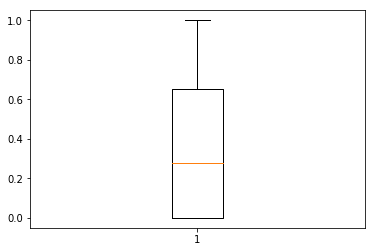

In [101]:
plt.boxplot(df10m_nonan['bc_30'])

In [99]:
bcdf = df10m.merge(df10m_nonan['bc_30'], how='outer', left_index=True, right_index=True)
bcdf['bc_30'].fillna(255, inplace=True)
bcplot = np.reshape(np.array(bcdf['bc_30']), (6282, 6331))

(-0.5, 6330.5, 6281.5, -0.5)

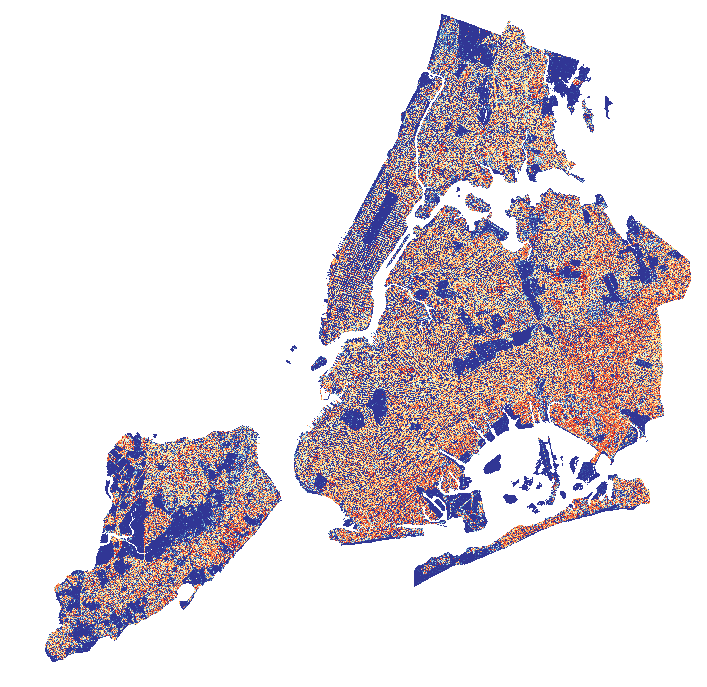

In [100]:
plt.figure(figsize=(12,12))
cmap=plt.cm.RdYlBu_r
cmap.set_over('white')
plt.imshow(bcplot, vmin=0, vmax=1, cmap=cmap)
plt.axis('off')

In [135]:
with rio.open(tifFolder + 'Historical_Water_Bodies.tif') as src:
    hwb_ras = src.read()
    hwb_meta = src.profile
    
print(hwb_meta)

{'count': 1, 'crs': CRS.from_epsg(32618), 'interleave': 'band', 'dtype': 'uint8', 'driver': u'GTiff', 'transform': Affine(7.500035678781709, 0.0, 562667.8236606269,
       0.0, -7.500035678781776, 4530170.840125717), 'height': 6282, 'width': 6331, 'blockxsize': 128, 'tiled': True, 'blockysize': 128, 'nodata': 255.0}


In [136]:
# change datatype to 'uint8'
bctif = bcplot.astype('uint8')

#writing and saving as raster
with rio.open('bc.tif', 'w', **hwb_meta) as dst:
    dst.write(bctif, 1)

### Two-Step Method

In [114]:
# relabel positives as 1, unlabeled as -1, negatives as 0. No negatives in this case yet
ys = 2 * y - 1

In [115]:
# use rf model with n_estimator=50 (above) to generate reliable negatives
pred = rf.predict_proba(X)[:,1]

In [116]:
# find range of scores given to known positives
range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]
print(range_P)

[0.0, 0.6600099255583126]


In [117]:
iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
iN_new = ys[(ys < 0) & (pred <= range_P[0])].index

In [118]:
ys.loc[iP_new] = 1
ys.loc[iN_new] = 0

In [119]:
TSM = RandomForestClassifier(n_estimators = 30, n_jobs = -1)

In [122]:
for i in range(10):
    # If step 1 didn't find new labels, we're done
    if len(iP_new) + len(iN_new) == 0 and i > 0:
        print('end')
        break
    
    print('Step 1 labeled %d new positives and %d new negatives.' % (len(iP_new), len(iN_new)))
    print('Doing step 2... ')

    # Retrain on new labels and get new scores
    TSM.fit(X, ys)
    pred = TSM.predict_proba(X)[:,-1]

    # Find the range of scores given to positive data points
    range_P = [min(pred * (ys > 0)), max(pred * (ys > 0))]

    # Repeat step 1
    iP_new = ys[(ys < 0) & (pred >= range_P[1])].index
    iN_new = ys[(ys < 0) & (pred <= range_P[0])].index
    ys.loc[iP_new] = 1
    ys.loc[iN_new] = 0

Step 1 labeled 0 new positives and 7989181 new negatives.
Doing step 2... 
Step 1 labeled 1 new positives and 399 new negatives.
Doing step 2... 
Step 1 labeled 0 new positives and 53 new negatives.
Doing step 2... 
Step 1 labeled 0 new positives and 24 new negatives.
Doing step 2... 
Step 1 labeled 0 new positives and 17 new negatives.
Doing step 2... 
Step 1 labeled 0 new positives and 11 new negatives.
Doing step 2... 
Step 1 labeled 0 new positives and 2 new negatives.
Doing step 2... 
Step 1 labeled 0 new positives and 2 new negatives.
Doing step 2... 
Step 1 labeled 0 new positives and 2 new negatives.
Doing step 2... 
end


In [123]:
df10m_nonan['tsm'] = pred
df10m_nonan['tsm'].describe()

count    1.374635e+07
mean     1.124016e-03
std      2.913172e-03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.587489e-03
max      8.666667e-01
Name: tsm, dtype: float64

(-0.001, 0.004)

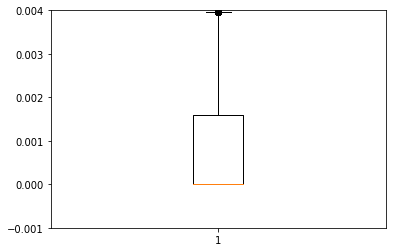

In [131]:
plt.boxplot(df10m_nonan['tsm'])
plt.ylim(-0.001, 0.004)

In [127]:
tsmSorted = df10m_nonan.sort_values('tsm', ascending=False)

tsm10 = tsmSorted[:1374634]
unCounts_tsm = len(tsm10[(tsm10['observed']==1)&(tsm10['y_un_30pct']==0)])
pctPos_tsm = unCounts_tsm*100.0/6500
print('Percentage of hidden positives in top 10 percent uncovered: %.2f percent' %pctPos_tsm)

tsm15 = tsmSorted[:2061952]
unCounts_tsm = len(tsm15[(tsm15['observed']==1)&(tsm15['y_un_30pct']==0)])
pctPos_tsm = unCounts_tsm*100.0/6500
print('Percentage of hidden positives in top 15 percent uncovered: %.2f percent' %pctPos_tsm)

tsm20 = tsmSorted[:2749268]
unCounts_tsm = len(tsm20[(tsm20['observed']==1)&(tsm20['y_un_30pct']==0)])
pctPos_tsm = unCounts_tsm*100.0/6500
print('Percentage of hidden positives in top 20 percent uncovered: %.2f percent' %pctPos_tsm)

Percentage of hidden positives in top 10 percent uncovered: 30.40 percent
Percentage of hidden positives in top 15 percent uncovered: 40.75 percent
Percentage of hidden positives in top 20 percent uncovered: 50.15 percent


In [125]:
tsmdf = df10m.merge(df10m_nonan['tsm'], how='outer', left_index=True, right_index=True)
tsmdf['tsm'].fillna(255, inplace=True)
tsmplot = np.reshape(np.array(tsmdf['tsm']), (6282, 6331))

(-0.5, 6330.5, 6281.5, -0.5)

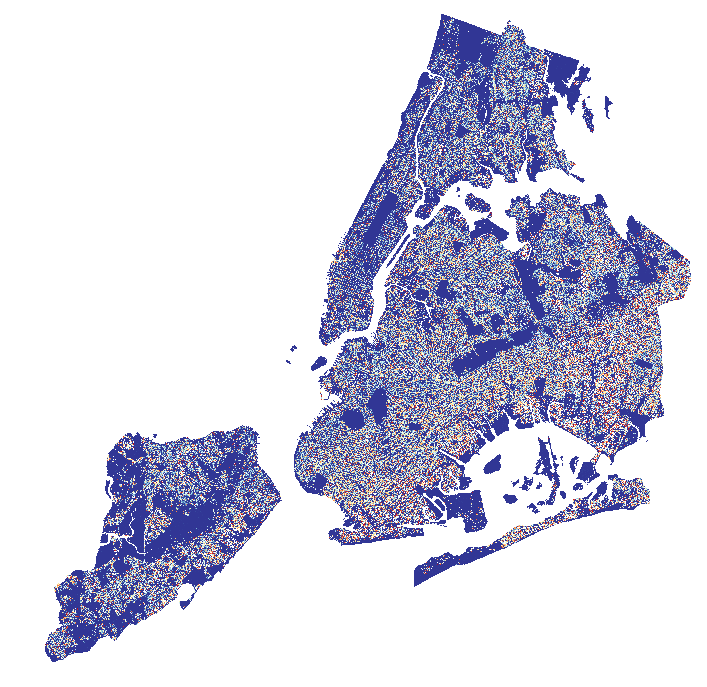

In [132]:
plt.figure(figsize=(12,12))
cmap=plt.cm.RdYlBu_r
cmap.set_over('white')
plt.imshow(tsmplot, vmin=0, vmax=0.004, cmap=cmap)
plt.axis('off')

In [137]:
with rio.open(tifFolder + 'Historical_Water_Bodies.tif') as src:
    hwb_ras = src.read()
    hwb_meta = src.profile
    
print(hwb_meta)

{'count': 1, 'crs': CRS.from_epsg(32618), 'interleave': 'band', 'dtype': 'uint8', 'driver': u'GTiff', 'transform': Affine(7.500035678781709, 0.0, 562667.8236606269,
       0.0, -7.500035678781776, 4530170.840125717), 'height': 6282, 'width': 6331, 'blockxsize': 128, 'tiled': True, 'blockysize': 128, 'nodata': 255.0}


In [138]:
# change datatype to 'uint8'
tsmtif = tsmplot.astype('uint8')

#writing and saving as raster
with rio.open('tsm.tif', 'w', **hwb_meta) as dst:
    dst.write(tsmtif, 1)

### One-Class Cassification SVM (kernel: rbf)

In [139]:
# to perform SVM, have to normalize features
# create copy of df10m_nonan

df10m_norm = df10m_nonan.copy()

df10m_norm['twi'] = (df10m_nonan['twi'] - df10m_nonan['twi'].mean())/df10m_nonan['twi'].std()
df10m_norm['hwb'] = (df10m_nonan['hwb'] - df10m_nonan['hwb'].mean())/df10m_nonan['hwb'].std()
df10m_norm['imp'] = (df10m_nonan['imp'] - df10m_nonan['imp'].mean())/df10m_nonan['imp'].std()
df10m_norm['cs'] = (df10m_nonan['cs'] - df10m_nonan['cs'].mean())/df10m_nonan['cs'].std()
df10m_norm['ss'] = (df10m_nonan['ss'] - df10m_nonan['ss'].mean())/df10m_nonan['ss'].std()
df10m_norm['ds'] = (df10m_nonan['ds'] - df10m_nonan['ds'].mean())/df10m_nonan['ds'].std()
df10m_norm['os'] = (df10m_nonan['os'] - df10m_nonan['os'].mean())/df10m_nonan['os'].std()
df10m_norm['bm'] = (df10m_nonan['bm'] - df10m_nonan['bm'].mean())/df10m_nonan['bm'].std()
df10m_norm.head()

,twi,hwb,imp,cs,ss,ds,os,bm,observed,y_un_30pct,gmmscore,gmmscore_exp,rf_30,bc_30,tsm
225463,-1.357629,-0.339194,-1.967857,-0.962542,-0.710288,2.736843,-0.265981,0.510256,0,0,-27.039072,1.807509e-12,0.0,0.0,0.0
231793,-1.010156,-0.339194,-1.967857,-0.962542,-0.710288,2.736843,-0.265981,0.510256,0,0,-26.546548,2.957881e-12,0.0,0.0,0.0
231794,0.379735,-0.339194,-1.967857,-0.962542,-0.710288,2.736843,-0.265981,0.510256,0,0,-25.581105,7.767253e-12,0.0,0.0,0.0
231795,0.987812,-0.339194,-1.967857,-0.962542,-0.710288,2.736843,-0.265981,0.510256,0,0,-25.664189,7.147999e-12,0.0,0.0,0.0
231796,-0.575815,-0.339194,-1.967857,-0.962542,-0.710288,2.736843,-0.265981,0.510256,0,0,-26.072172,4.753347e-12,0.0,0.0,0.0


In [140]:
# train on labeled positives and test on unknown labels
# hidden positives should show up as 1s (inliers)
occX_train = df10m_norm[df10m_norm['y_un_30pct'] == 1].iloc[:, :8]
occX_test = df10m_norm[df10m_norm['y_un_30pct'] != 1].iloc[:, :8]

In [155]:
OCC = OneClassSVM(random_state=13, kernel='rbf')
OCC.fit(occX_train)

/nfshome/rms818/.conda/envs/myEnv/lib/python2.7/site-packages/sklearn/svm/classes.py:1137: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
      kernel='rbf', max_iter=-1, nu=0.5, random_state=13, shrinking=True,
      tol=0.001, verbose=False)

In [156]:
values, counts = np.unique(OCC.predict(occX_train), return_counts=True)
print(values)
print(counts)

[-1  1]
[7717 7702]


In [157]:
df10m_norm['occ_rbf'] = OCC.predict(df10m_norm.iloc[:,:8])

In [158]:
unCounts_occ = df10m_norm[(df10m_norm['observed']==1)&(df10m_norm['y_un_30pct']==0)]['occ_rbf'].value_counts()

In [166]:
pct_occ = unCounts_occ[1]*100.0/6500
print('%.2f percent of hidden positives uncovered.' %pct_occ)

50.00 percent of hidden positives uncovered.


In [167]:
occdf = df10m.merge(df10m_norm['occ_rbf'], how='outer', left_index=True, right_index=True)
occdf['occ_rbf'].fillna(255, inplace=True)
occplot = np.reshape(np.array(occdf['occ_rbf']), (6282, 6331))

In [172]:
np.unique(occplot)

array([ -1.,   1., 255.])

(-0.5, 6330.5, 6281.5, -0.5)

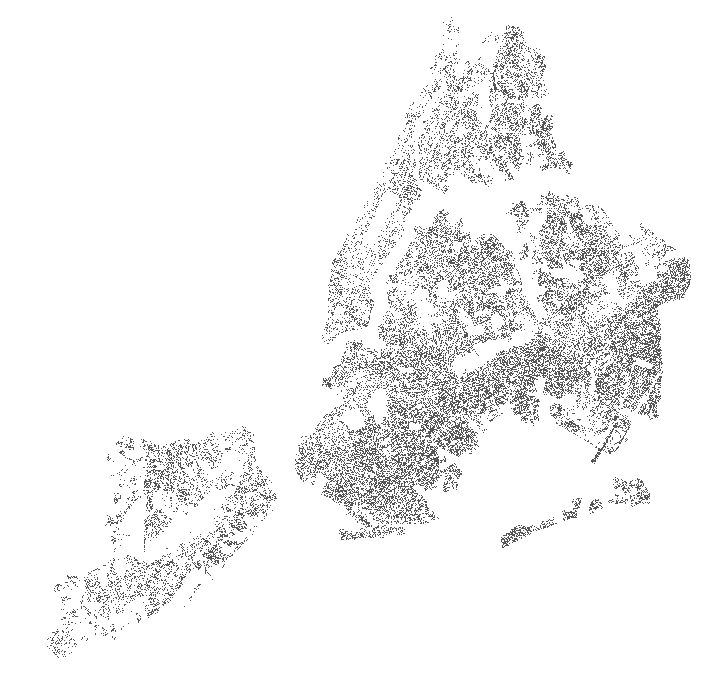

In [183]:
plt.figure(figsize=(12,12))
cmap = plt.cm.binary
cmap.set_over('white')
plt.imshow(occplot, vmin=-1, vmax=2, cmap=cmap)
plt.axis('off')

In [184]:
with rio.open(tifFolder + 'Historical_Water_Bodies.tif') as src:
    hwb_ras = src.read()
    hwb_meta = src.profile
    
print(hwb_meta)

{'count': 1, 'crs': CRS.from_epsg(32618), 'interleave': 'band', 'dtype': 'uint8', 'driver': u'GTiff', 'transform': Affine(7.500035678781709, 0.0, 562667.8236606269,
       0.0, -7.500035678781776, 4530170.840125717), 'height': 6282, 'width': 6331, 'blockxsize': 128, 'tiled': True, 'blockysize': 128, 'nodata': 255.0}


In [185]:
# change datatype to 'uint8'
occrbftif = occplot.astype('uint8')

#writing and saving as raster
with rio.open('occ_rbf.tif', 'w', **hwb_meta) as dst:
    dst.write(occrbftif, 1)

### OneClass SVM (kernel: sigmoid)

In [207]:
OCC2 = OneClassSVM(random_state=13, kernel='sigmoid')
OCC2.fit(occX_train)

/nfshome/rms818/.conda/envs/myEnv/lib/python2.7/site-packages/sklearn/svm/classes.py:1137: DeprecationWarning: The random_state parameter is deprecated and will be removed in version 0.22.
  " be removed in version 0.22.", DeprecationWarning)


OneClassSVM(cache_size=200, coef0=0.0, degree=3, gamma='auto_deprecated',
      kernel='sigmoid', max_iter=-1, nu=0.5, random_state=13,
      shrinking=True, tol=0.001, verbose=False)

In [208]:
values, counts = np.unique(OCC.predict(occX_train), return_counts=True)
print(values)
print(counts)

[-1  1]
[7717 7702]


In [212]:
df10m_norm['occ_sig'] = OCC2.predict(df10m_norm.iloc[:,:8])

In [213]:
unCounts_occ2 = df10m_norm[(df10m_norm['observed']==1)&(df10m_norm['y_un_30pct']==0)]['occ_sig'].value_counts()

In [214]:
pct_occ2 = unCounts_occ2[1]*100.0/6500
print('%.2f percent of hidden positives uncovered.' %pct_occ2)

49.95 percent of hidden positives uncovered.


In [216]:
occ2df = df10m.merge(df10m_norm['occ_sig'], how='outer', left_index=True, right_index=True)
occ2df['occ_sig'].fillna(255, inplace=True)
occ2plot = np.reshape(np.array(occ2df['occ_sig']), (6282, 6331))

(-0.5, 6330.5, 6281.5, -0.5)

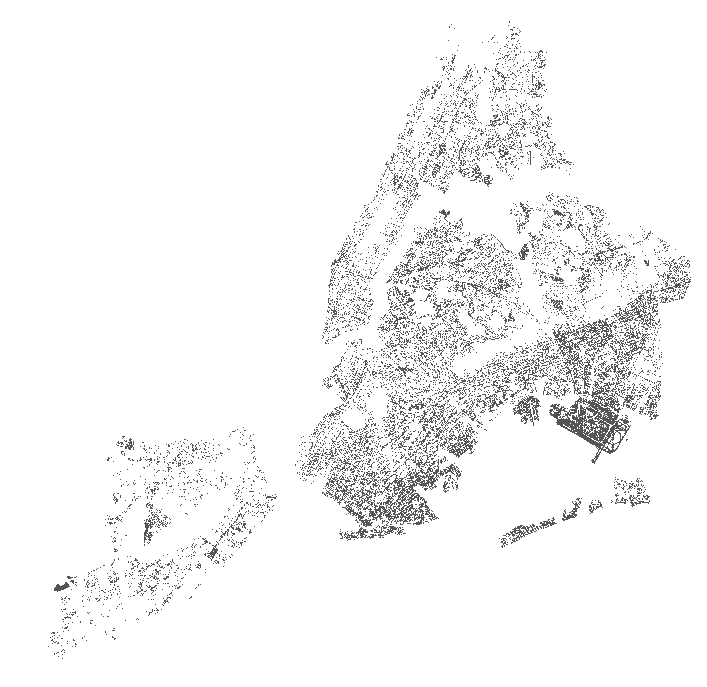

In [217]:
plt.figure(figsize=(12,12))
cmap = plt.cm.binary
cmap.set_over('white')
plt.imshow(occ2plot, vmin=-1, vmax=2, cmap=cmap)
plt.axis('off')

In [218]:
with rio.open(tifFolder + 'Historical_Water_Bodies.tif') as src:
    hwb_ras = src.read()
    hwb_meta = src.profile
    
print(hwb_meta)

{'count': 1, 'crs': CRS.from_epsg(32618), 'interleave': 'band', 'dtype': 'uint8', 'driver': u'GTiff', 'transform': Affine(7.500035678781709, 0.0, 562667.8236606269,
       0.0, -7.500035678781776, 4530170.840125717), 'height': 6282, 'width': 6331, 'blockxsize': 128, 'tiled': True, 'blockysize': 128, 'nodata': 255.0}


In [219]:
# change datatype to 'uint8'
occsigtif = occ2plot.astype('uint8')

#writing and saving as raster
with rio.open('occ_sig.tif', 'w', **hwb_meta) as dst:
    dst.write(occsigtif, 1)